In [1]:
import os
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def read_all_weight_data():
    home = os.path.expanduser('~')
    db = f"{home}/db/weight-data.db"
    query = "SELECT * FROM WEIGHT"
    with sqlite3.connect(db) as conn:
        df = pd.read_sql(query, conn)
    return df

def process_weight_data(data: list):
    df = pd.DataFrame(data)
    df.drop('datetime', inplace=True, axis='columns')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df['time'] = df['timestamp'].dt.time
    df['7-pt-MA'] = df['loss'].rolling(7).mean()
    return df

def time_dist_plot(df, bins=8):
    plt.figure(figsize=(10, 5))
    hours = df['timestamp'].dt.hour + df['timestamp'].dt.minute/60
    hours.name = "Hour of day"
    plt.hist(hours, bins=bins, color='#66b3ff')
    plt.title("Hour of day when weighed",
              weight='bold',
              size=10)
    print(hours.describe(percentiles=[0.5]).round(2))
    
def weight_loss_plot(df):
    plt.figure(figsize=(15, 6))
    plt.plot(df['timestamp'], df['loss'],
             label='Loss (KG)',
             marker="o",
             markersize=10,
             color='#66b3ff',
             linewidth=3)
    plt.plot(df['timestamp'], df['7-pt-MA'],
             alpha=0.75,
             label='7 pt MA',
             color='#ff9999',
             linewidth=2)
    plt.legend(bbox_to_anchor=[0.98, 0.2])
    curr_loss = df.iloc[-1]['loss']
    plt.hlines(curr_loss,
               xmin=df['timestamp'].min(),
               xmax=df['timestamp'].max(),
               linewidth=2.5,
               colors='#ffcc90',
               linestyles='--',
               label=str(curr_loss))
    plt.text(x=df['timestamp'].max(),
             y=curr_loss*1.03,
             s=f"{curr_loss}",
             weight='bold',
             size=15);
    plt.title(f"Total weighings: {len(df)}",
              weight='bold', size=15)
    plt.xticks(rotation=30)
    plt.grid()
    plt.show()

In [3]:
weight_data = read_all_weight_data()
df = process_weight_data(weight_data)

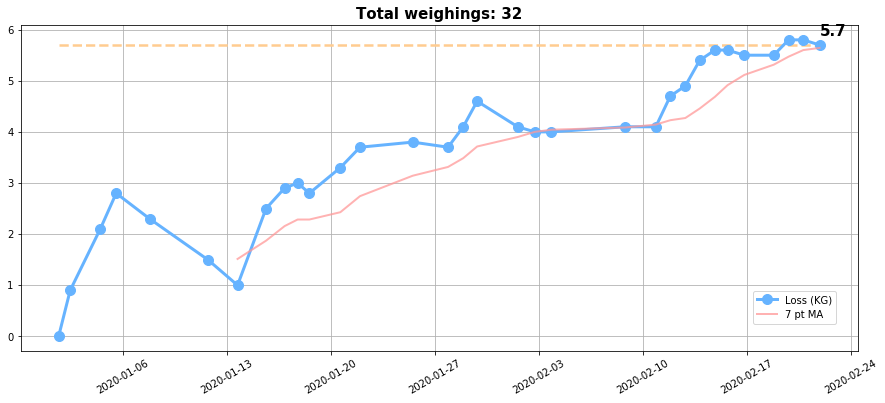

In [4]:
weight_loss_plot(df)

count    32.00
mean     17.71
std       3.25
min      10.67
50%      19.00
max      22.75
Name: Hour of day, dtype: float64


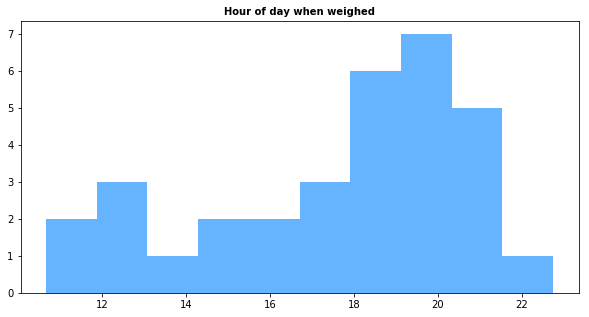

In [5]:

time_dist_plot(df, bins=10)